# Spatial Aggregation of Evidence

Consider a system consisting of $N$ agents which are spatially distributed on a unit square with periodic boundary conditions. Each agent has made a _True/False_ decision about some arbitrary problem. The decision of each agent is _True_ with a given probability.

At each time instance, each agent $i$ does the following to estimate what fraction of agents has voted _True_:

- __Move:__ Randomly moves a small distance in space.
- __Aggregate:__ Increases its evidence variable $E_i$ for every other agent $j$ in the system that has voted _True_ ($v_j = 1$). The amount by which the variable increases depends inversely of the distance $d_{i,j}$ between the two agents.
- __Forget:__ Decreases its evidence variable $E_i$ by a constant fraction $\tau$ of its current value.

Therefore,
$$ E_i(t+1) = E_i(t) + \sum\limits_{{j \neq i} \\ {v_j=1}} \frac{\lambda}{d_{i,j}} - \tau E_i(t) $$

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## The Decision Making Agent

Each `Agent` is characterized by its spatial co-ordinates `x` and `y`, its `decision` regarding the aribtrary problem and the `evidence` that it has gathered. Initially the agents are distributed randomly on the unit square and have `evidence = 0`. Their decision state can be `decision = True` with probability `p`.

As the time evolves, the agents move randomly. The `wrap` function implements the periodic boundary conditions on the system and brings any agents which have the unit square back inside it.

In [2]:
class Agent:

    def __init__(self,p):
        (self.x, self.y) = np.random.random(2)

        self.evidence = 0.0

        if np.random.random() < p:
            self.decision = True
        else:
            self.decision = False

    def wrap(self):
        if self.x > 1:
            self.x -= 1
        elif self.x < 0:
            self.x += 1

        if self.y > 1:
            self.y -= 1
        elif self.y < 0:
            self.y += 1

## Computing Distance Between the Agents

The function `dist_matrix` computes the pairwise Eucledian distance between the agents. _It also takes note of the possibly reduced distance between the nodes due to periodic boundary conditions._

In [3]:
def dist_matrix(S):

    DD = np.zeros((len(S),len(S)))
    for ii in range(len(S)):
        for jj in range(len(S)):
            if abs(S[ii].x - S[jj].x) < 0.5:
                xd = abs(S[ii].x - S[jj].x)
            else:
                xd = 1 - abs (S[ii].x - S[jj].x)
            if abs(S[ii].y - S[jj].y) < 0.5:
                yd = abs(S[ii].y - S[jj].y)
            else:
                yd = 1 - abs (S[ii].y - S[jj].y)
            DD[ii,jj] = np.sqrt(xd**2 + yd**2)
    return DD

## Connecting the Agents

If the agents are to be connected to agents only within a `threshold` distance, the `connect` function may be used. This funcion is not used in the current model.

In [4]:
def connect(S,threshold):

    D = dist_matrix(S)
    C = np.empty((len(D),len(D)), dtype = bool)

    for ii in range(len(D)):
        for jj in range(len(D)):
            if D[ii,jj] < threshold:
                C[ii,jj] = True
            else:
                C[ii,jj] = False

    return C

## Updating Evidence Variable

Given the positions of the agents, the `gather_evidence` function updates the `evidence` variable of the `Agent` according to the equation,

$$ E_i(t+1) = E_i(t) + \sum\limits_{j \neq i \\ v_j = 1} \frac{\lambda}{d_{i,j}} - \tau E_i(t) $$

where $E_i$ is the `evidence` variable of `Agent` $i$.

In [5]:
def gather_evidence(S,N,lam,tau):

    Dist = dist_matrix(S)
    for j in range(N):
        S[j].evidence -= S[j].evidence * tau
        for k in range(N):
            if j != k:
                if S[k].decision == True:
                    S[j].evidence += lam/Dist[j,k]
                    #S[j].evidence += np.exp(-lam * Dist[j,k]**2)

## Moving the Agents

At each time step, the $x_i$ and $y_i$ variables are updated by adding a random number drawn from a normal distribution with $\sigma^2 = dr$. The `move` function updates the `x` and `y` variables of the `Agent` accordingly and also invokes the `wrap` function to accomodate for the periodic boundary conditions.

In [6]:
def move(S,N,dr):

    for j in range(N):

        S[j].x += np.sqrt(dr)*np.sign(np.random.randn())
        S[j].y += np.sqrt(dr)*np.sign(np.random.randn())

        S[j].wrap()

## Normalizing the Evidence

At equilibrium, the evidence $E_i$ must satisfy

$$ E_i = \frac{1}{\tau} \sum\limits_{j \neq i \\ v_j = 1} \frac{\lambda}{d_{i,j}}. $$

The maximum value of $E_i$ occurs when all the agents have voted _True_ (_i.e._ $v_i = 1 ~~ \forall i$). In that case, the evidence at equilibrium becomes,

$$ E_{max} = \frac{\lambda}{\tau}\left( N-1 \right) \tilde{d} $$

where $\tilde{d}$ is the average inverse distance between points in a unit square. We compute this $E_{max}$ in the function `normalization` to be used as a normalization for the evidence gathered.

In [7]:
def normalization(NP, λ, τ):
    
    S = [Agent(1) for i in range(NP)]
    D = dist_matrix(S)
    I = np.zeros((NP,NP))
    
    assert len(D) == NP
    
    for i in range(NP):
        for j in range(NP):
            if i!=j:
                I[i,j] = 1.0/D[i,j]
    
    return (np.mean(np.mean(I)))*(NP-1)*λ/τ

## Setting the System Parameters

The system parameters include total simulation time `Total_Time`, movement step size `dr`, number of agents `N`, $\lambda$ `lam`, $\tau$ `tau` and probability of being true `prob`.

In [8]:
def set_parameters(Total_Time=10000, dr=0.0001, N=100, lam=0.1, tau=0.018, prob=1.0, horizon=100, tolerance=0.1, threshold=0.7):
    
    para = {
        
        'dr': dr,
        'total': Total_Time,
        'N': N,

        'lam': lam,
        'tau': tau,

        'prob': prob,
        
        'horizon': horizon,
        'tolerance': tolerance,
        
        'threshold': threshold
        
    }
    
    return para

## The Simulation Function

Given a set of parameters, we now define the `simulate` function which evolves the system gives the output `out` which contains positions of the agents `positions`, evidence gathered by each agent `evidence_individual` and the mean of this evidence over all agents `evidence_mean` for each timestep.

In [13]:
def simulate(para):
    
    pos = np.zeros((para['total'],para['N'],2))

    ZZ = np.zeros(para['total'])
    Z = np.zeros((para['total'],para['N']))
    
    Decision_Time = np.zeros(para['N'])
    Decision_Value = np.zeros(para['N'])
    Decision_Profile_Time = []
    Decision_Profile_Value = []

    S = [Agent(para['prob']) for i in range(para['N'])]
    D = np.array([False for i in range(para['N'])])
    M = set()
    
    L = np.zeros(para['N'])    
    U = np.zeros(para['N'])
    
    norm_factor = normalization(para['N'],para['lam'],para['tau'])

    for i in range(para['total']):
        
        if i%para['horizon'] == 0:
            print(int(i/para['horizon']), len(M), end=',\t')
            Decision_Profile_Time.append(i)
            Decision_Profile_Value.append(len(M))
            if len(M) == para['N']:
                break

        gather_evidence(S,para['N'],para['lam'],para['tau'])

        for j in range(para['N']):
            
            if i%para['horizon'] == 0:
                if D[j] == True or abs(0.5*(U[j]+L[j]) - S[j].evidence)/norm_factor < 0.1*para['tolerance']:
                    Decision_Time[j] = i
                    Decision_Value[j] = S[j].evidence/norm_factor > para['threshold']
                    M = M.union({j})
                D[j] = True
                L[j] = (1-para['tolerance'])*S[j].evidence
                U[j] = (1+para['tolerance'])*S[j].evidence

            pos[i,j,0] = S[j].x
            pos[i,j,1] = S[j].y

            Z[i,j] = S[j].evidence

            move(S,para['N'],para['dr'])
            
            if S[j].evidence < L[j] or S[j].evidence > U[j]:
                D[j] = False

    ZZ += np.mean(Z, axis=1)
    
    out = {
        'positions': pos,
        'evidence_individual': Z/norm_factor,
        'evidence_mean': ZZ/norm_factor,
        'decision_time': Decision_Time,
        'decision_value': Decision_Value,
        'profile_time': np.array(Decision_Profile_Time),
        'profile_value': np.array(Decision_Profile_Value)
    }
    
    return out

## Set Plotting Axes

Set the plot size and axes labels

In [10]:
def set_plotter_axes(size, xlabel, ylabel):
    plt.figure(figsize=size)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

Plot Evidence v/s Time Lines

In [11]:
def evidence_plotter(N, output, color, label):
    for i in range(N):
        plt.plot(output['evidence_individual'][:,i],color,alpha=0.03)
    plt.plot(output['evidence_mean'],color,label=label)
    plt.xlim((0,max(output['decision_time'])))
    plt.ylim((0,1.2*max(output['decision_value'])))

Plot Traces of a Particular Agent

In [12]:
def position_plotter(N, output, index, ti, tf):
    plt.plot(output['positions'][ti:tf,index,0], output['positions'][ti:tf,index,1], '.r')
    plt.show()

## Running the Code

### Single Run

__Caution:__ Code takes about 10-12 minutes to fun

0 0,	1 0,	2 0,	3 2,	4 45,	5 50,	

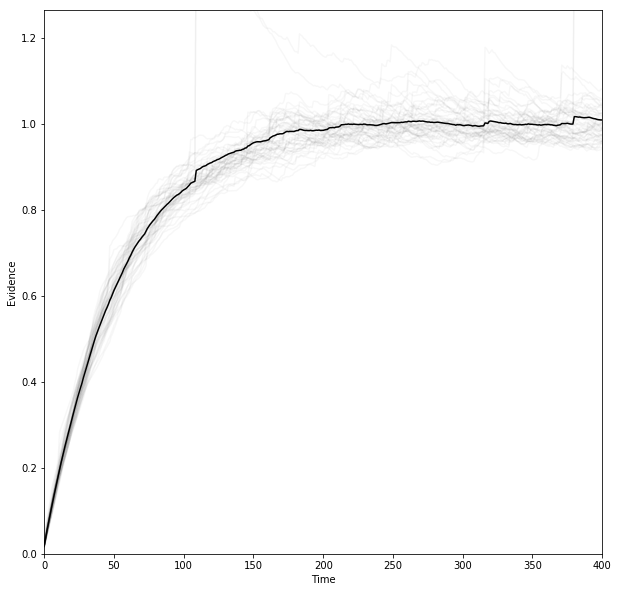

In [13]:
set_plotter_axes((10,10), 'Time', 'Evidence')
para = set_parameters(N=50)
output = simulate(para)
evidence_plotter(para['N'],output,'k','')
plt.show()

## Self-declaring agents


0
0 0,	1 0,	2 0,	3 31,	4 44,	5 58,	6 69,	7 79,	8 87,	9 88,	10 91,	11 94,	12 97,	13 98,	14 99,	15 99,	16 99,	17 99,	18 99,	19 99,	20 100,	
1
0 0,	1 0,	2 0,	3 31,	4 44,	5 59,	6 70,	7 81,	8 86,	9 90,	10 95,	11 96,	12 97,	13 98,	14 98,	15 98,	16 99,	17 99,	18 99,	19 99,	20 99,	21 99,	22 99,	23 99,	24 100,	
2
0 0,	1 0,	2 0,	3 34,	4 48,	5 60,	6 68,	7 82,	8 85,	9 87,	10 95,	11 96,	12 98,	13 99,	14 99,	15 99,	16 100,	
3
0 0,	1 0,	2 0,	3 31,	4 46,	5 64,	6 68,	7 80,	8 84,	9 86,	10 95,	11 97,	12 97,	13 98,	14 98,	15 99,	16 100,	
4
0 0,	1 0,	2 0,	3 35,	4 56,	5 66,	6 74,	7 81,	8 83,	9 86,	10 94,	11 96,	12 96,	13 97,	14 99,	15 99,	16 100,	
5
0 0,	1 0,	2 0,	3 35,	4 56,	5 66,	6 74,	7 81,	8 83,	9 86,	10 94,	11 96,	12 96,	13 97,	14 99,	15 99,	16 100,	
6
0 0,	1 0,	2 0,	3 38,	4 54,	5 65,	6 73,	7 82,	8 83,	9 86,	10 94,	11 96,	12 97,	13 98,	14 98,	15 99,	16 99,	17 99,	18 99,	19 99,	20 100,	
7
0 0,	1 0,	2 0,	3 38,	4 54,	5 65,	6 73,	7 82,	8 83,	9 86,	10 94,	11 96,	12 97,	13 98,	14 98,	15 99,	16 99,	17 99,	18

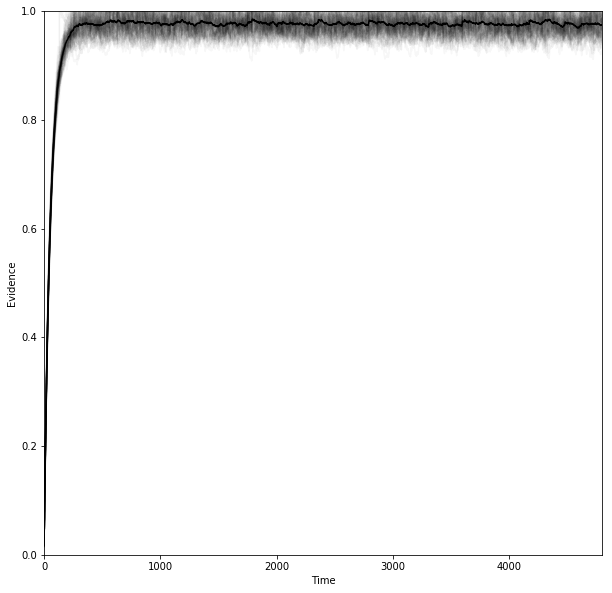

In [16]:
pr = np.zeros(20)
ti = np.zeros(20)
de = np.zeros(20)

for i in range(20):
    print()
    print(i)
    pp = 0.5+(0.5/20)*i
    pr[i] = pp
    np.random.seed(200)
    para = set_parameters(N=100, prob=pp, tolerance=0.05, horizon=400)
    output = simulate(para)
    ti[i] = max(output['decision_time'])
    de[i] = sum(output['decision_value'])
    
set_plotter_axes((10,10), 'Time', 'Evidence')
evidence_plotter(para['N'],output,'k','')
plt.ylim((0,1))
plt.show()

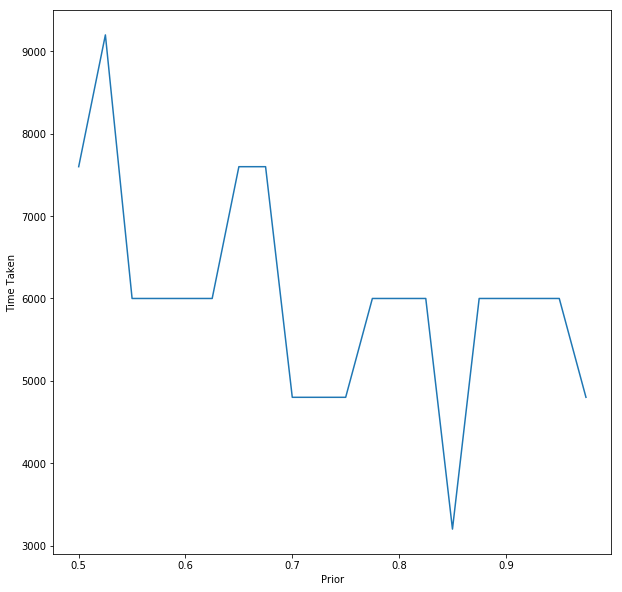

In [17]:
set_plotter_axes((10,10), 'Prior', 'Time Taken')
plt.plot(pr,ti)
plt.show()

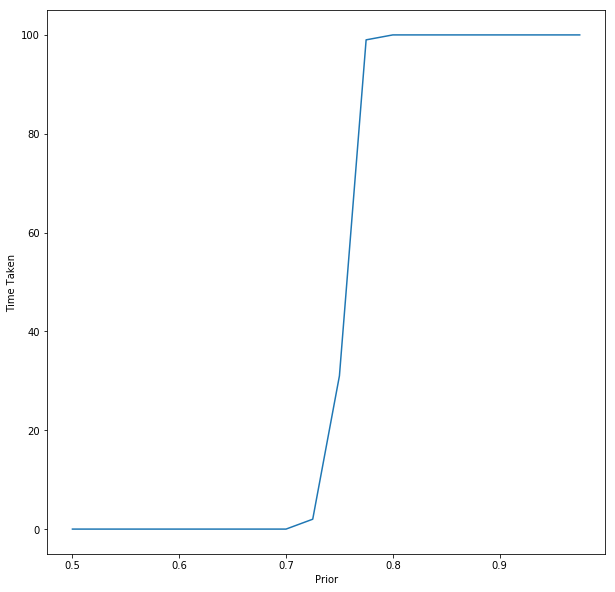

In [18]:
set_plotter_axes((10,10), 'Prior', 'Time Taken')
plt.plot(pr,de)
plt.show()

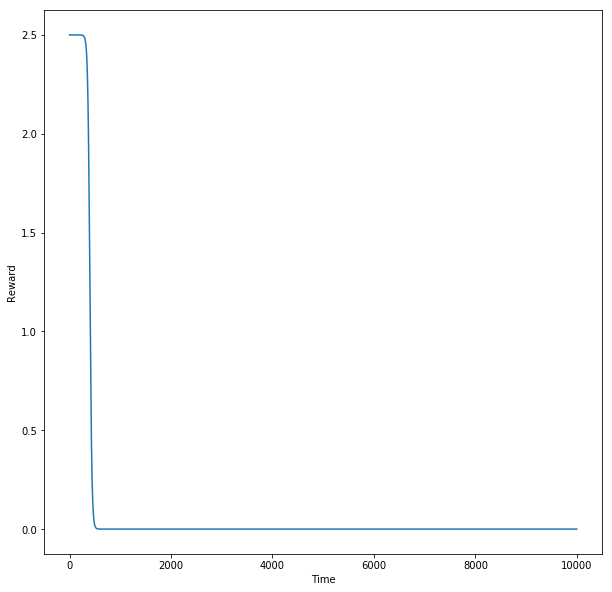

In [30]:
rc = 2.5
k = 0.05
ip = 400

set_plotter_axes((10,10), 'Time', 'Reward')

times = np.linspace(0, 10000, 10000)
reward_correct = rc/(1+np.exp(k*(times-ip)))
plt.plot(times,reward_correct)

plt.show()

In [31]:
reward = np.mean(rc/(1+np.exp(k*(output['decision_time']-ip))))
reward

5.152884045475511e-09

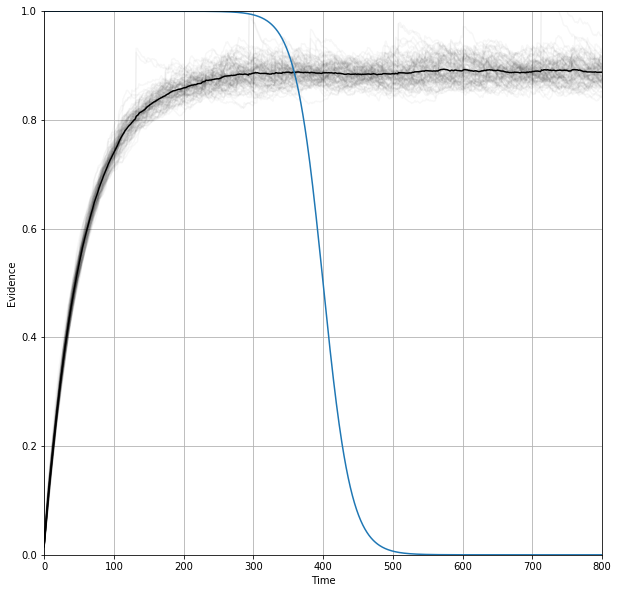

In [32]:
set_plotter_axes((10,10), 'Time', 'Evidence')
evidence_plotter(para['N'],output,'k','')
plt.bar(list(output['profile_time']), list(output['profile_value']/para['N']), width=-para['horizon'], align='edge', alpha=0.5)
plt.plot(times,reward_correct/max(reward_correct))
plt.ylim((0,1))
plt.grid()
plt.show()

In [83]:
def compute_reward(time):
    pass

### Showcase Run

__Caution:__ Code takes about 3 hours minutes to run

100%|██████████| 10000/10000 [32:33<00:00,  5.41it/s]


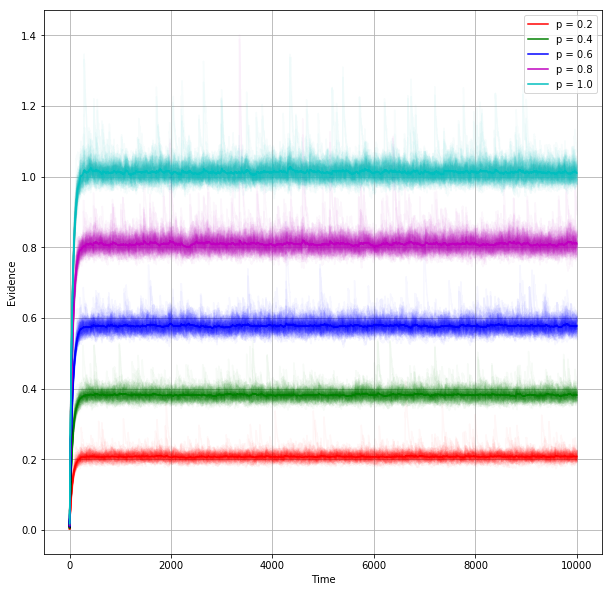

In [14]:
set_plotter_axes((10,10), 'Time', 'Evidence')
pp = [0.2,0.4, 0.6, 0.8, 1.0]
cc = ['r', 'g', 'b', 'm', 'c']
assert len(pp)==len(cc)
for i in range(len(pp)):
    para = set_parameters(N=100,prob=pp[i])
    output = simulate(para)
    ll = 'p = '+str(pp[i])
    evidence_plotter(para['N'],output,cc[i],ll)
plt.legend()
plt.grid()
plt.savefig('Evidence_Gathering.png')
plt.savefig('Evidence_Gathering.pdf')
plt.show()